In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import copy
from ast import Param
import json
import math

from utils.prune import apply_mask
from utils.count_improvement import improvements
from utils.normalize import normalize_weights

In [16]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [18]:
net = Net().to(device)
varianzas_net = Net().to(device)
individuo = Net().to(device)

Cargamos los datos

In [19]:
# Definimos el transform para los datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargamos el dataset de MNIST
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Definimos los DataLoaders para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

In [20]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Realizamos el "entrenamiento"

In [21]:
# train loop
train_loss = []
train_loss_mean = []
test_accuracies = []
n_individuo = 1
accuracy_threshold = 0.4

# Multiplicamos los pesos de varianzas para que sean numero sgrandes
with torch.no_grad():
    for param in varianzas_net.parameters():
        param *= 10000

#Guardo el mejor individuo y la red original que tendrá que ser reestablecida cad epoca
best_individo_state_dict = individuo.state_dict()
net_state_dict = net.state_dict()

#train loop
while True:
    net.load_state_dict(net_state_dict)
    if n_individuo == 1:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, individuo)
        #guardar el estado de la red en un txt en una carpeta
        # with open(f'pesos/individuo{n_individuo}.txt', 'w') as f:
        #     f.write(str(masked_net.state_dict()))
        #masked_net.train()
        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            #loss.backward()
            #optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        #train_loss_mean.append(np.mean(train_loss))
        test_accuracies.append(accuracy)
        #print(f"Accuracy: {accuracy}, loss mean: {train_loss_mean[-1]}")
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        best_loss = train_loss[-1]
        if accuracy > accuracy_threshold:
            break
        n_individuo += 1

        #sumamos varianzas para crear un nuevo individuo desde el anterior
        nuevo_individuo = Net().to(device)
        state_dict_ind = individuo.state_dict()
        state_dict_var = varianzas_net.state_dict()
        state_dict_suma = {}

        for key in state_dict_ind:
            if state_dict_ind[key].size() == state_dict_var[key].size():  
                std_dev = state_dict_var[key]
                noise = torch.normal(0, torch.abs(std_dev))
                state_dict_suma[key] = state_dict_ind[key] + torch.sign(std_dev) * noise
            else:
                state_dict_suma[key] = state_dict_ind[key]

        nuevo_individuo.load_state_dict(state_dict_suma)
        
    else:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, nuevo_individuo)
        #guardar el estado de la red en un txt en una carpeta
        # with open(f'pesos/individuo{n_individuo}.txt', 'w') as f:
        #     f.write(str(masked_net.state_dict()))
        
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        if accuracy > accuracy_threshold:
            break

        # Verificamos que individuo tiene mejor desempeño
        if train_loss[-1] < best_loss:
            print("Nuevo mejor individuo")
            best_loss = train_loss[-1]
            best_individo_state_dict = nuevo_individuo.state_dict()
        
        # actualizamos el individuo
        individuo.load_state_dict(best_individo_state_dict)

        if n_individuo >10:
            # actualizmos el vector de varianzas
            if improvements(train_loss) > 2:## +mejoras que peoras (lejos de la solucion)
                print("Aumentando varianzas")
                with torch.no_grad():
                    for param in varianzas_net.parameters():
                        param *= (1/0.82)

            elif improvements(train_loss) <= 2: ## -mejoras que peoras (cerca de la solucion)
                print("Disminuyendo varianzas")
                with torch.no_grad():
                    for param in varianzas_net.parameters():
                        param *= 0.82
        
            else:
                pass

        #sumamos varianzas para crear un nuevo individuo desde el anterior
        nuevo_individuo = Net().to(device)
        state_dict_ind = individuo.state_dict()
        state_dict_var = varianzas_net.state_dict()
        state_dict_suma = {}

        for key in state_dict_ind:
            if state_dict_ind[key].size() == state_dict_var[key].size():  
                std_dev = state_dict_var[key]
                noise = torch.normal(0, torch.abs(std_dev))
                state_dict_suma[key] = state_dict_ind[key] + torch.sign(std_dev) * noise
            else:
                state_dict_suma[key] = state_dict_ind[key]

        nuevo_individuo.load_state_dict(state_dict_suma)

        n_individuo += 1         

 --------------------- Individuo 1 --------------------- 
Accuracy: 0.0958 Loss: 2.3068562491870384
 --------------------- Individuo 2 --------------------- 
Accuracy: 0.1033 Loss: 2.301184325075861
Nuevo mejor individuo
 --------------------- Individuo 3 --------------------- 
Accuracy: 0.1024 Loss: 2.3039807175268243
 --------------------- Individuo 4 --------------------- 
Accuracy: 0.0953 Loss: 2.3031323426313746
 --------------------- Individuo 5 --------------------- 
Accuracy: 0.0958 Loss: 2.3013792350602302
 --------------------- Individuo 6 --------------------- 
Accuracy: 0.1293 Loss: 2.30259380716759
 --------------------- Individuo 7 --------------------- 
Accuracy: 0.0682 Loss: 2.3024722215717537
 --------------------- Individuo 8 --------------------- 
Accuracy: 0.0821 Loss: 2.301462109154984
 --------------------- Individuo 9 --------------------- 
Accuracy: 0.1119 Loss: 2.302201222255032
 --------------------- Individuo 10 --------------------- 
Accuracy: 0.1068 Loss: 2

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000019C7F351F80>
Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\popen_spawn_win32.p

KeyboardInterrupt: 

In [22]:
print(train_loss)
print(test_accuracies)
print(max(test_accuracies))

[2.3068562491870384, 2.301184325075861, 2.3039807175268243, 2.3031323426313746, 2.3013792350602302, 2.30259380716759, 2.3024722215717537, 2.301462109154984, 2.302201222255032, 2.302724525618401, 2.302136819754074, 2.302317641691358, 2.301341566703975, 2.301010205293261, 2.3013413498904915, 2.302246855011881, 2.3020498826305493, 2.301498569405155, 2.301289194682514, 2.3016950308895314, 2.303149446749738, 2.303214760477355, 2.302159160184962, 2.3022524514940503, 2.300949010259307, 2.3013515762174563, 2.302087294013261, 2.30413076389573, 2.303978937266986, 2.3050892543691055, 2.3028295177386515, 2.302046080896341, 2.304607517429506, 2.2992805303541073, 2.3012057286081538, 2.303300616075235, 2.303978978189578, 2.3027085894460617, 2.303370436117339, 2.300337943186892, 2.30285263849474, 2.302249642069152, 2.3018500421092964, 2.3030933606853363, 2.3043308286016178, 2.304034384583105, 2.3030903967204632, 2.30436527983212, 2.302788956841426, 2.3022829375541543, 2.3029451484619172, 2.30373266561

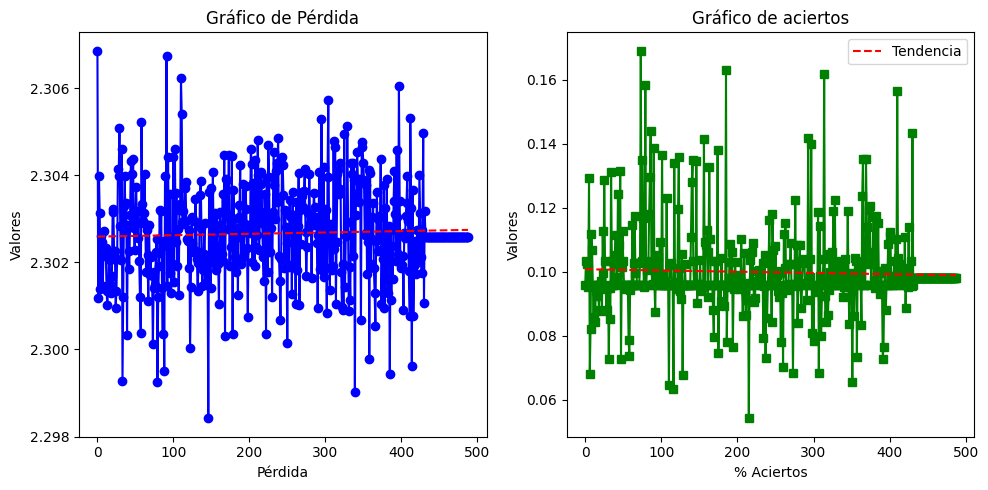

In [23]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Pérdida")
plt.ylabel("Valores")

# Calcular la regresión lineal para train_loss
epochs = np.arange(len(train_loss))
m, b = np.polyfit(epochs, train_loss, 1)
plt.plot(epochs, m*epochs + b, color='red', linestyle='--', label='Tendencia')


# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("% Aciertos")
plt.ylabel("Valores")

# Calcular la regresión lineal para test_accuracies
epochs_test = np.arange(len(test_accuracies))
m, b = np.polyfit(epochs_test, test_accuracies, 1)
plt.plot(epochs_test, m*epochs_test + b, color='red', linestyle='--', label='Tendencia')

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.legend()
plt.show()

In [ ]:
# while epoch <= 1:
#             net = apply_mask(net, individuo)
#             #guardar el estado de la red en un txt en una carpeta
#             with open(f'pesos/individuo{n_individuo}_epoch{epoch}.txt', 'w') as f:
#                 f.write(str(net.state_dict()))
#             net.train()
#             running_loss = 0.0
#             # Train for 1 epoch
#             for i, data in enumerate(train_loader, 0):
#                 inputs, labels = data[0].to(device), data[1].to(device)
#                 optimizer.zero_grad()
#                 outputs = net(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#                 running_loss += loss.item()
#             train_loss.append(running_loss / len(train_loader))
#             print(f"Epoch: {epoch}, Loss: {train_loss[-1]}")

#             epoch += 1